# Testing models on LFW and Personal Data datasets

## Packages and Subsidiary Functions

In [ ]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning
!pip install facenet-pytorch
!pip install faiss-gpu
!pip install numpy==1.16.2

     |████████████████████████████████| 409kB 8.2MB/s 
     |████████████████████████████████| 276kB 19.3MB/s 
     |████████████████████████████████| 829kB 24.7MB/s 
     |████████████████████████████████| 2.8MB 44.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=e79f9b0408acabbb5c9bd9b6872af27446d26a901403e9dc3a52e48381551c5b
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=fcc09642d9eebbd735914b45d83e122f58834fecb350ad7e592edc3329353833
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unin

In [ ]:
import gdown
from google.colab import drive
import os
import shutil
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, models, transforms
import tensorboard
import pytorch_lightning as pl
import json
from pytorch_lightning.callbacks import ModelCheckpoint
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from google.colab import drive
from pytorch_metric_learning import losses, miners, distances, reducers, testers, samplers, regularizers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm 
from sklearn.preprocessing import normalize
import tarfile
import numpy as np
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Sun Sep 20 19:48:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Function that display tensor as an image.

In [ ]:
def display_tensor(x, title=None):
   image = tensor_to_image(x)
   plt.imshow(image)
   if title is not None:
      plt.title('ID osoby: {}'.format(title))

Functions for evaluation metrics and ROC calculations. 

In [ ]:
def evaluate(distances, labels, thresholds_roc_start = 0.1,thresholds_roc_end =1.5,thresholds_roc_step = 0.1, diagonal_excl=True):
    # Calculate evaluation metrics
    thresholds = np.arange(thresholds_roc_start ,thresholds_roc_end ,thresholds_roc_step)
    tpr, fpr, accuracy, best_threshold_index = calculate_roc(thresholds, distances,labels, diagonal_excl)
    plot_roc(fpr, tpr, figure_name="roc.png")
    print('the best accuracy:',  accuracy[best_threshold_index]  ,'True Positive rate:',  tpr[best_threshold_index] ,'False Positive rate:', fpr[best_threshold_index],'threshold:',thresholds[best_threshold_index])
   

def calculate_roc(thresholds, distances, labels, diagonal_excl): 
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    
    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    
    
    acc = np.zeros((nrof_thresholds))

    for threshold_idx, threshold in enumerate(thresholds):
       tprs[threshold_idx], fprs[threshold_idx], acc[threshold_idx] = calculate_accuracy(threshold, distances, labels,diagonal_excl)
    best_threshold_index = np.argmax(acc)

    return tprs, fprs, acc , best_threshold_index

def calculate_accuracy(threshold, dist, actual_issame, diagonal_excl):
    predict_issame = np.less(dist, threshold)
    if diagonal_excl==True:
      tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)
    else: 
      tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    if diagonal_excl==True:
      acc = float(tp + tn) / (dist.size-len(dists))
    else:  acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def plot_roc(fpr, tpr, figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='#16a085',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='#2c3e50', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", frameon=False)
    fig.savefig(figure_name, dpi=fig.dpi)

In [ ]:
def calculate_accuracy_s(threshold, dist, actual_issame): # accuracy - delete dist=0
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))-len(dists)#hd
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / ((len(dists)*len(dists[0]))-len(dists)) #acc = float(tp + tn) / dist.size
    return tp,fp,tn,fn,tpr, fpr, acc

Needed repositories downloading.

In [ ]:
!git clone https://github.com/TreB1eN/InsightFace_Pytorch.git

Cloning into 'InsightFace_Pytorch'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 14.35 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Datasets downloading

### Personal Photos

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM'
output = 'faces_folder.zip'
gdown.download(url, output, False)
!unzip -o faces_folder.zip
!rm faces_folder.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1zmRmId5xFU4MRrDZ9j5EgYv5bhFlv1nM
To: /content/faces_folder.zip
124MB [00:00, 148MB/s] 


Archive:  faces_folder.zip
   creating: Faces_Folder/
   creating: Faces_Folder/DD/
  inflating: Faces_Folder/DD/DD_100_143.jpg  
  inflating: Faces_Folder/DD/DD_100_4850.jpg  
  inflating: Faces_Folder/DD/DD_100_600.jpg  
  inflating: Faces_Folder/DD/DD_100_7510.jpg  
  inflating: Faces_Folder/DD/DD_100_4711.jpg  
  inflating: Faces_Folder/DD/DD_100_1410.jpg  
  inflating: Faces_Folder/DD/DD_100_6550.jpg  
  inflating: Faces_Folder/DD/DD_100_6050.jpg  
  inflating: Faces_Folder/DD/DD_100_1371.jpg  
  inflating: Faces_Folder/DD/DD_100_6570.jpg  
  inflating: Faces_Folder/DD/DD_100_5170.jpg  
  inflating: Faces_Folder/DD/DD_100_1841.jpg  
  inflating: Faces_Folder/DD/DD_100_7250.jpg  
  inflating: Faces_Folder/DD/DD_100_2720.jpg  
  inflating: Faces_Folder/DD/DD_100_3050.jpg  
  inflating: Faces_Folder/DD/DD_100_6590.jpg  
  inflating: Faces_Folder/DD/DD_100_7550.jpg  
  inflating: Faces_Folder/DD/DD_100_4360.jpg  
  inflating: Faces_Folder/DD/DD_100_8900.jpg  
  inflating: Faces_Folder

### LFW

In [ ]:
url = 'https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY'
output = 'lfw.tgz'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?id=1vfjmbep7UtbY76j81T0jcF4ePbTw-oMY
To: /content/lfw.tgz
181MB [00:02, 62.9MB/s]


'lfw.tgz'

In [ ]:
tar = tarfile.open('lfw.tgz')
tar.extractall()
tar.close()

## Models validation

### FaceNet (trained on VGGFace2 dataset)

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
for name, param in resnet.named_parameters():
  param.requires_grad = False    

In [ ]:
for name, param in resnet.named_parameters():
  if param.requires_grad == True:
    print(name)

#### MTCNN application on Personal Photos

MTCNN function importing and applying on Personal Photos.

In [ ]:
data_dir = '/content/Faces_Folder'

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999936
Face detected with probability: 0.999685
Face detected with probability: 0.963283
Face detected with probability: 0.999923
Face detected with probability: 0.999978
Face detected with probability: 0.999768
Face detected with probability: 0.998523
Face detected with probability: 0.999973
Face detected with probability: 0.999828
Face detected with probability: 0.999982
Face detected with probability: 0.999680
Face detected with probability: 0.999941
Face detected with probability: 0.999993
Face detected with probability: 0.999999
Face detected with probability: 0.999987
Face detected with probability: 0.999969
Face detected with probability: 0.999999
Face detected with probability: 0.999951
Face detected with probability: 0.951586
Face detected with probability: 0.999889
Face detected with probability: 0.999988
Face detected with probability: 0.999250
Face detected with probability: 0.999998
Face detected with probability: 0.995928
Face detected wi

Number of photos for model validation after MTCNN application.

In [ ]:
len(names)

1151

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in names]

In [ ]:
aligned = torch.stack(aligned).to(device)

In [ ]:
aligned.size()

torch.Size([1151, 3, 160, 160])

#### Model validation results on Personal Photos

Calculation of all parts needed for meatrices creation.

In [ ]:
resnet_vggface2.to(device).eval()

output_embeddings = []

for image in data_loader:
  output = resnet_vggface2(image.to(device))
  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

Number of calculated embeddings.

In [ ]:
len(output_embeddings)

1151

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]

In [ ]:
output= []
for x in names:
    if x not in output:
        output.append(x)
print(output)

['AM', 'AS', 'BO', 'DD', 'KWD', 'OO', 'RO', 'TM', 'ZBD', 'ZD']


Calculating validation metrices for FaceNet model.

the best accuracy: 0.9004933328296755 True Positive rate: 0.775806021599929 False Positive rate: 0.040006428169667964 threshold: 1.0999999999999996


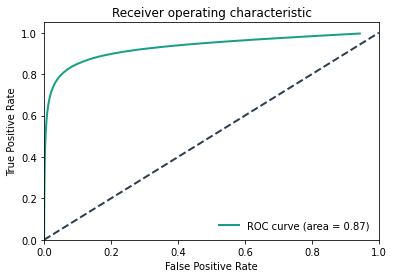

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)

#### MTCNN application on LFW dataset

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('lfw')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Streaming output truncated to the last 5000 lines.
Face detected with probability: 0.999999
Face detected with probability: 0.999994
Face detected with probability: 0.999940
Face detected with probability: 1.000000
Face detected with probability: 0.999999
Face detected with probability: 0.999976
Face detected with probability: 0.999996
Face detected with probability: 0.999999
Face detected with probability: 0.999922
Face detected with probability: 0.999893
Face detected with probability: 0.999955
Face detected with probability: 0.999901
Face detected with probability: 0.999998
Face detected with probability: 1.000000
Face detected with probability: 0.999999
Face detected with probability: 0.999897
Face detected with probability: 0.999992
Face detected with probability: 0.999998
Face detected with probability: 0.979991
Face detected with probability: 0.999899
Face detected with probability: 0.999975
Face detected with probability: 0.999995
Face detected with probability: 0.999977
Face d

In [ ]:
aligned = torch.stack(aligned).to(device)

Number of photos and each photo size after MTCNN function.

In [ ]:
aligned.size()

torch.Size([13233, 3, 160, 160])

#### Model validation results on MFW dataset

Calculation of elements needed to calculate validation metrices.

In [ ]:
dataset = aligned
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader

In [ ]:
resnet_vggface2.to(device).eval()

output_embeddings = []
output_labels = []
output_dir = []
output_dict = {}

for image in data_loader:
  output = resnet_vggface2(image.to(device))
  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

Number of embeddings.

In [ ]:
len(output_embeddings)

13233

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('lfw')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in tqdm(names)]

In [ ]:
output= []
for x in names:
    if x not in output:
        output.append(x)
print(output)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

Calculating validation metrices for FaceNet model.

the best accuracy: 0.999419334390929 True Positive rate: 0.8451974555946784 False Positive rate: 0.00015273641985671504 threshold: 0.8299999999999996


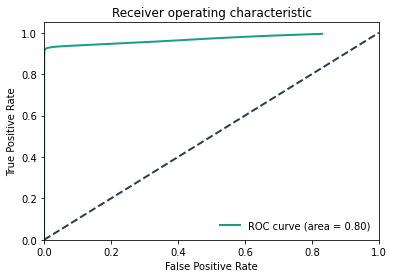

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)

### FaceNet (trained on CASIA dataset)

In [ ]:
resnet_casia = InceptionResnetV1(
    classify=False,
   pretrained='casia-webface'
).to(device)

In [ ]:
for names, params in resnet_casia.named_parameters():
  params.requires_grad = False

In [ ]:
for name, param in resnet_casia.named_parameters():
  if param.requires_grad == True:
    print(name)

#### MTCNN application on Personal Photos

MTCNN function importing and applying on Personal Photos.

In [ ]:
data_dir = '/content/Faces_Folder'

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999936
Face detected with probability: 0.999685
Face detected with probability: 0.963283
Face detected with probability: 0.999923
Face detected with probability: 0.999978
Face detected with probability: 0.999768
Face detected with probability: 0.998523
Face detected with probability: 0.999973
Face detected with probability: 0.999828
Face detected with probability: 0.999982
Face detected with probability: 0.999680
Face detected with probability: 0.999941
Face detected with probability: 0.999993
Face detected with probability: 0.999999
Face detected with probability: 0.999987
Face detected with probability: 0.999969
Face detected with probability: 0.999999
Face detected with probability: 0.999951
Face detected with probability: 0.951586
Face detected with probability: 0.999889
Face detected with probability: 0.999988
Face detected with probability: 0.999250
Face detected with probability: 0.999998
Face detected with probability: 0.995928
Face detected wi

Number of photos for model validation after MTCNN application.

In [ ]:
len(names)

1151

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in names]

In [ ]:
aligned = torch.stack(aligned).to(device)

In [ ]:
aligned.size()

torch.Size([1151, 3, 160, 160])

#### Model validation results on Personal Photos

Calculation of all parts needed for meatrices creation.

In [ ]:
resnet_casia.to(device).eval()

output_embeddings = []

for image in data_loader:
  output = resnet_casia(image.to(device))
  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

Number of calculated embeddings.

In [ ]:
len(output_embeddings)

1151

In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

In [ ]:
output= []
for x in names:
    if x not in output:
        output.append(x)
print(output)

['AM', 'AS', 'BO', 'DD', 'KWD', 'OO', 'RO', 'TM', 'ZBD', 'ZD']


Calculating validation metrices for FaceNet model.

the best accuracy: 0.8943421599365391 True Positive rate: 0.7779435632866691 False Positive rate: 0.05011293936986081 threshold: 1.1599999999999995


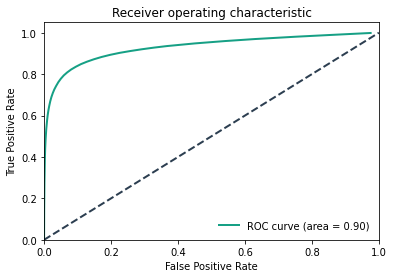

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)

### MobileFaceNet

Importing model from repo.

In [ ]:
%cd '/content/InsightFace_Pytorch'
from model import MobileFaceNet
%cd ..

/content/InsightFace_Pytorch
/content


Downloading parameters estimated with ArcFace loss function.

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo'
output = 'model_mobilefacenet_arcface.pth'
gdown.download(url, output, False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1NofDYM1xnQUopTNMx4Qsieb_XUJ208mo
To: /content/model_mobilefacenet_arcface.pth
4.94MB [00:00, 29.5MB/s]


'model_mobilefacenet_arcface.pth'

Setting up embedding size and loading parametres (transfer learning)

In [ ]:
mobilefacenet = MobileFaceNet(embedding_size=512)
mobilefacenet.load_state_dict(torch.load('model_mobilefacenet_arcface.pth'))

<All keys matched successfully>

MobileFaceNet architecture.

In [ ]:
mobilefacenet

MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

Removing gradinet from parameters.

In [ ]:
for names, params in mobilefacenet.named_parameters():
  params.requires_grad = False

for names, params in mobilefacenet.named_parameters():
  if params.requires_grad = True: 
    print(name)


#### MTCNN application on Personal Photos

MTCNN function importing and applying on Personal Photos.

In [ ]:
data_dir = '/content/Faces_Folder'

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    aligned.append(trans(x_aligned))
    names.append(dataset.idx_to_class[y])

100%|██████████| 1205/1205 [04:49<00:00,  4.17it/s]


Execution time calculation.

In [ ]:
time_ = []

for x, _ in tqdm(loader):
  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    
  diff = time.time() - start_
  time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

100%|██████████| 13233/13233 [09:33<00:00, 23.09it/s]


Total time(sec): 558.52, Average(sec):0.04, fps:23.69



Number of photos after MTCNN funtion.

In [ ]:
len(names)

991

#### Model validation results on Personal Photos

Calculation of all parts needed for meatrices creation.

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in tqdm(names)]

100%|██████████| 991/991 [00:00<00:00, 20069.89it/s]


In [ ]:
aligned = torch.stack(tuple(aligned)).to(device)

In [ ]:
dataset = aligned.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([991, 3, 112, 112])

MobileFaceNet embedding calculation


In [ ]:
mobilefacenet.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):

  output = mobilefacenet(image.to(device))

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

991it [00:05, 170.44it/s]


Execution time of MobileFaceNet embedding calculation.

In [ ]:
time_ = []

mobilefacenet.to(device).eval()

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet(image.to(device))
    
  diff = time.time() - start_
  time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

991it [00:05, 184.16it/s]


Total time(sec): 5.26, Average(sec):0.01, fps:188.46



In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

991

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 991/991 [00:11<00:00, 83.01it/s]


Validation metrices calculation.

the best accuracy: 0.8187526118908561 True Positive rate: 0.638718752562558 False Positive rate: 0.0952827006252786 threshold: 1.1899999999999995


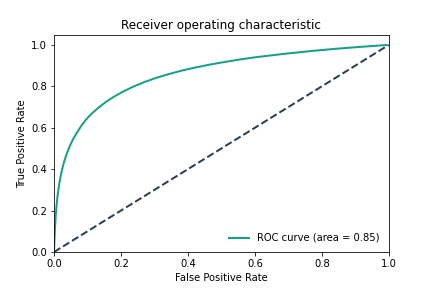

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.1, thresholds_roc_end=1.5,thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

In [ ]:
# tp,fp,tn,fn,tpr, fpr, acc = calculate_accuracy_s(1.189999999,np.array(dists),np.array(dists2))

#### MTCNN application on Personal Photos

MTCNN function importing and applying on LFW dataset

In [ ]:
data_dir = '/content/lfw'

In [ ]:
%cd '/content/InsightFace_Pytorch'
from mtcnn import MTCNN
mtcnn = MTCNN()
%cd ..

/content/InsightFace_Pytorch
/content


In [ ]:
def collate_fn(x):
    return x[0]

workers = 0 if os.name == 'nt' else 4

dataset = datasets.ImageFolder(data_dir)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [ ]:
aligned = []
names = []
trans = transforms.ToTensor()

for x, y in tqdm(loader):
  
  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    aligned.append(trans(x_aligned))
    names.append(dataset.idx_to_class[y])

100%|██████████| 13233/13233 [09:55<00:00, 22.23it/s]


Time execution.

In [ ]:
time_ = []

for x, _ in tqdm(loader):
  start_ = time.time()

  try:
    _, landmarks = mtcnn.detect_faces(x)
  except:
    landmarks = []

  if len(landmarks) != 0:
    x_aligned = mtcnn.align(x)
    
  diff = time.time() - start_
  time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

100%|██████████| 13233/13233 [09:27<00:00, 23.32it/s]


Total time(sec): 553.06, Average(sec):0.04, fps:23.93



Number of photos after MTCNN application.

In [ ]:
len(names)

13059

#### Model validation results on MFW dataset

Calculation of needed elements for validation metrices.

In [ ]:
dists2 = [[e2==e1 for e2 in names] for e1 in tqdm(names)]

100%|██████████| 13059/13059 [00:09<00:00, 1429.69it/s]


In [ ]:
aligned = torch.stack(tuple(aligned)).to(device)

In [ ]:
dataset = aligned.clone()
batch_size = 1

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=batch_size
)

In [ ]:
data_loader.dataset.size()

torch.Size([13059, 3, 112, 112])

In [ ]:
mobilefacenet.to(device).eval()

output_embeddings = []

for i, image in tqdm(enumerate(data_loader)):

  output = mobilefacenet(image.to(device))

  norm_output = normalize(np.array(output[0].cpu()).reshape(1,-1), norm='l2', axis=1)
  output_embeddings.append(np.array(norm_output))

13059it [01:16, 169.94it/s]


Execution time of embedding calculation by MobileFaceNet model.

In [ ]:
mobilefacenet.to(device).eval()

time_ = []

for i, image in tqdm(enumerate(data_loader)):
  start_ = time.time()

  output = mobilefacenet(image.to(device))
    
  diff = time.time() - start_
  time_.append(diff)

# Total time
total_time = np.array(time_).sum()
# Mean time
mean_diff = np.array(time_).mean()
# Frames per second 
fps = 1 / mean_diff

print("\nTotal time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))

13059it [01:12, 180.37it/s]


Total time(sec): 70.79, Average(sec):0.01, fps:184.48



In [ ]:
embeddings = torch.from_numpy(np.array(output_embeddings)).squeeze(1)

In [ ]:
len(output_embeddings)

13059

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in tqdm(embeddings)]

100%|██████████| 13059/13059 [35:04<00:00,  6.21it/s]


Validation metrices for MobileFaceNet calculation.

the best accuracy: 0.999311066423084 True Positive rate: 0.8117651958436582 False Positive rate: 0.00015927624273106604 threshold: 1.06


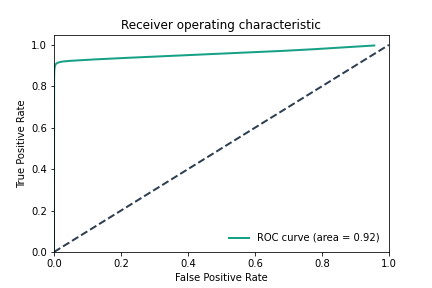

In [ ]:
evaluate(np.array(dists),np.array(dists2), thresholds_roc_start= 0.01, thresholds_roc_end=1.5, thresholds_roc_step=0.01, diagonal_excl=True)
Image.open('/content/roc.png')

In [ ]:
# tp,fp,tn,fn,tpr, fpr, acc = calculate_accuracy_s(1.06,np.array(dists),np.array(dists2))

true: 480230 false 170044192 tp: 389834 ,fp: 27084 ,tn: 170017108 ,fn: 90396 ,tpr: 0.8117651958436582 fpr: 0.00015927624273106604 acc: 0.999311066423084
